# Validación con Imágenes Sintéticas

Este notebook valida el pipeline de registro usando imágenes sintéticas con transformaciones conocidas (ground truth).

## Objetivos

1. Generar imágenes sintéticas con transformaciones conocidas
2. Aplicar el pipeline de registro completo
3. Comparar las homografías estimadas con el ground truth
4. Calcular métricas de error (RMSE, error angular, etc.)
5. Documentar cómo los parámetros afectan la calidad del registro


In [22]:
# Importar librerías
import sys
sys.path.append('..')

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Importar módulos propios
from src import utils
from src.feature_detection import FeatureDetector, DetectorType
from src.matching import FeatureMatcher, MatcherType, get_matched_points
from src.registration import estimate_homography, validate_homography, compute_reprojection_error
from src.synthetic_generator import (generate_synthetic_dataset, visualize_synthetic_dataset,
                                     create_test_image, apply_combined_transform)

# Configuración
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

print("Librerías importadas correctamente")


Librerías importadas correctamente


## 1. Generación de Imágenes Sintéticas

Generamos un conjunto de imágenes sintéticas con transformaciones conocidas.


In [23]:
# Generar dataset sintético
print("Generando dataset sintético...")
dataset = generate_synthetic_dataset(n_images=4, output_dir='../data/synthetic')

print("\nDataset generado:")
for data in dataset:
    print(f"  Imagen {data['id']}: {data['parameters']}")


Generando dataset sintético...
Dataset sintético generado en: ../data/synthetic
Número de imágenes: 4

Dataset generado:
  Imagen 0: {'rotation': 0, 'translation': (0, 0), 'scale': 1.0}
  Imagen 1: {'rotation': 15, 'translation': (50, 30), 'scale': 1.0}
  Imagen 2: {'rotation': -10, 'translation': (-30, 40), 'scale': 0.95}
  Imagen 3: {'rotation': 20, 'translation': (20, -50), 'scale': 1.05}


Visualización guardada en: ../results/figures/05_synthetic_dataset.png


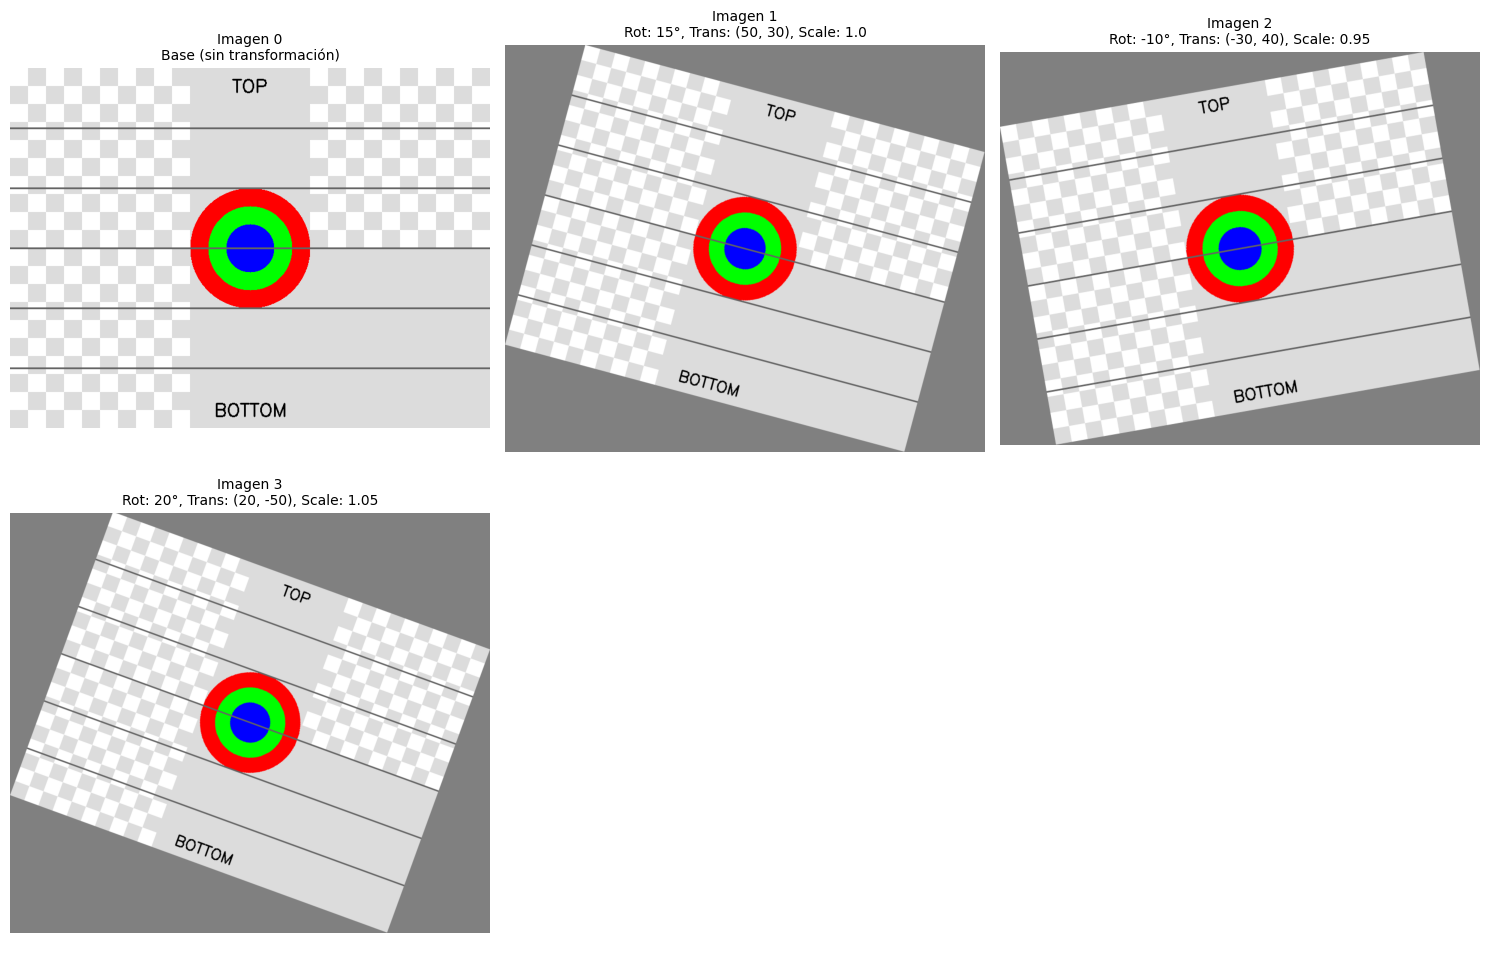

In [24]:
# Visualizar dataset
visualize_synthetic_dataset(dataset, '../results/figures/05_synthetic_dataset.png')


## 2. Pipeline de Registro en Imágenes Sintéticas

Aplicamos el pipeline completo: detección, matching, y estimación de homografía.


In [25]:
# Detector y matcher
detector = FeatureDetector(DetectorType.SIFT)
matcher = FeatureMatcher(MatcherType.BF, descriptor_type='SIFT')

# Procesar cada par de imágenes
results = []

for i in range(len(dataset) - 1):
    print(f"\n{'='*80}")
    print(f"Procesando par: Imagen {dataset[i]['id']} -> Imagen {dataset[i+1]['id']}")
    print('='*80)
    
    img1 = dataset[i]['image']
    img2 = dataset[i+1]['image']
    H_gt = dataset[i+1]['transformation']  # Ground truth
    
    # Detección de características
    kp1, desc1 = detector.detect_and_compute(img1)
    kp2, desc2 = detector.detect_and_compute(img2)
    print(f"Keypoints: {len(kp1)} y {len(kp2)}")
    
    # Matching
    matches = matcher.match_robust(desc1, desc2, ratio=0.75)
    print(f"Matches: {len(matches)}")
    
    # Extraer puntos
    points1, points2 = get_matched_points(kp1, kp2, matches)
    
    # Estimar homografía
    H_est, mask = estimate_homography(points1, points2, ransac_threshold=5.0)
    n_inliers = np.sum(mask) if mask is not None else 0
    print(f"Inliers: {n_inliers}/{len(matches)}")
    
    # Calcular error
    error = utils.compute_transformation_error(H_est, H_gt, img1.shape)
    print(f"RMSE: {error['rmse']:.2f} píxeles")
    print(f"Error Frobenius: {error['matrix_frobenius_error']:.4f}")
    
    results.append({
        'pair': (i, i+1),
        'H_estimated': H_est,
        'H_ground_truth': H_gt,
        'error': error,
        'n_matches': len(matches),
        'n_inliers': n_inliers,
        'keypoints': (kp1, kp2),
        'matches': matches
    })



Procesando par: Imagen 0 -> Imagen 1
Keypoints: 416 y 686
Matches: 136
Inliers: 93/136
RMSE: 45.87 píxeles
Error Frobenius: 64.9915

Procesando par: Imagen 1 -> Imagen 2
Keypoints: 686 y 703
Matches: 262
Inliers: 148/262
RMSE: 114.53 píxeles
Error Frobenius: 98.8668

Procesando par: Imagen 2 -> Imagen 3
Keypoints: 703 y 750
Matches: 250
Inliers: 149/250
RMSE: 119.03 píxeles
Error Frobenius: 147.9244


## 3. Análisis de Errores

Analizamos las métricas de error para cada par de imágenes.


In [26]:
# Crear tabla de resultados

print("RESUMEN DE RESULTADOS")

print(f"{'Par':<10} {'Matches':<10} {'Inliers':<10} {'RMSE':<15} {'Error Frobenius'}")
print("-"*80)

for r in results:
    pair_str = f"{r['pair'][0]} -> {r['pair'][1]}"
    print(f"{pair_str:<10} {r['n_matches']:<10} {r['n_inliers']:<10} "
          f"{r['error']['rmse']:<15.2f} {r['error']['matrix_frobenius_error']:.4f}")



# Estadísticas globales
all_rmse = [r['error']['rmse'] for r in results]
all_frob = [r['error']['matrix_frobenius_error'] for r in results]

print(f"\nEstadísticas Globales:")
print(f"  RMSE promedio: {np.mean(all_rmse):.2f} ± {np.std(all_rmse):.2f} píxeles")
print(f"  Error Frobenius promedio: {np.mean(all_frob):.4f} ± {np.std(all_frob):.4f}")


RESUMEN DE RESULTADOS
Par        Matches    Inliers    RMSE            Error Frobenius
--------------------------------------------------------------------------------
0 -> 1     136        93         45.87           64.9915
1 -> 2     262        148        114.53          98.8668
2 -> 3     250        149        119.03          147.9244

Estadísticas Globales:
  RMSE promedio: 93.14 ± 33.48 píxeles
  Error Frobenius promedio: 103.9276 ± 34.0458


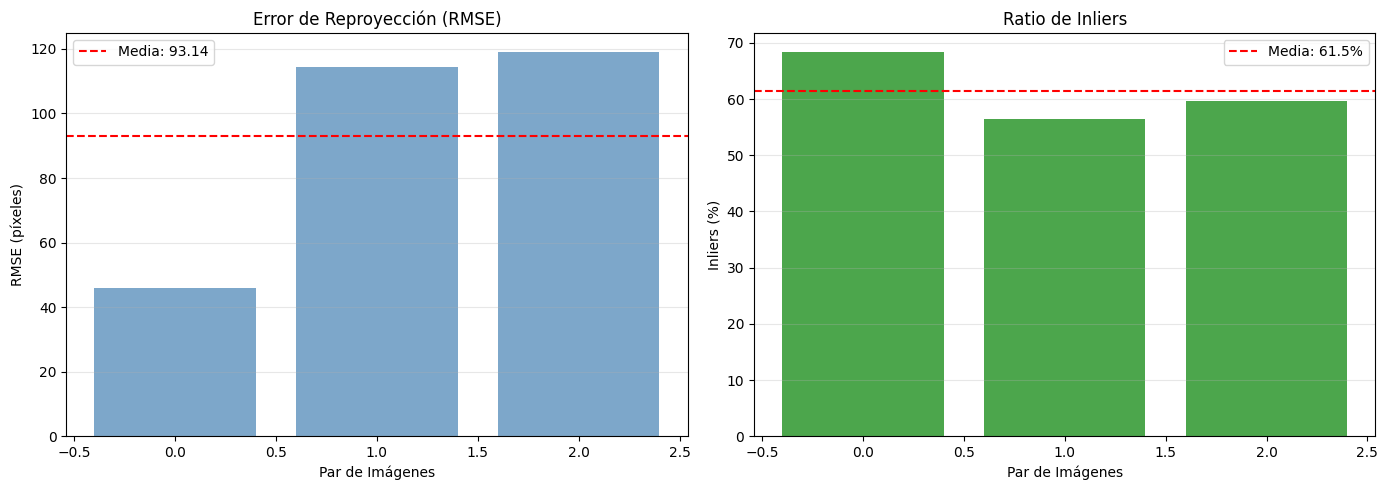

In [27]:
# Visualizar errores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de RMSE
axes[0].bar(range(len(results)), all_rmse, color='steelblue', alpha=0.7)
axes[0].axhline(np.mean(all_rmse), color='red', linestyle='--', 
                label=f'Media: {np.mean(all_rmse):.2f}')
axes[0].set_xlabel('Par de Imágenes')
axes[0].set_ylabel('RMSE (píxeles)')
axes[0].set_title('Error de Reproyección (RMSE)')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Gráfico de inliers
inlier_ratios = [r['n_inliers']/r['n_matches']*100 for r in results]
axes[1].bar(range(len(results)), inlier_ratios, color='green', alpha=0.7)
axes[1].axhline(np.mean(inlier_ratios), color='red', linestyle='--',
                label=f'Media: {np.mean(inlier_ratios):.1f}%')
axes[1].set_xlabel('Par de Imágenes')
axes[1].set_ylabel('Inliers (%)')
axes[1].set_title('Ratio de Inliers')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/06_validation_errors.png', dpi=300, bbox_inches='tight')
plt.show()


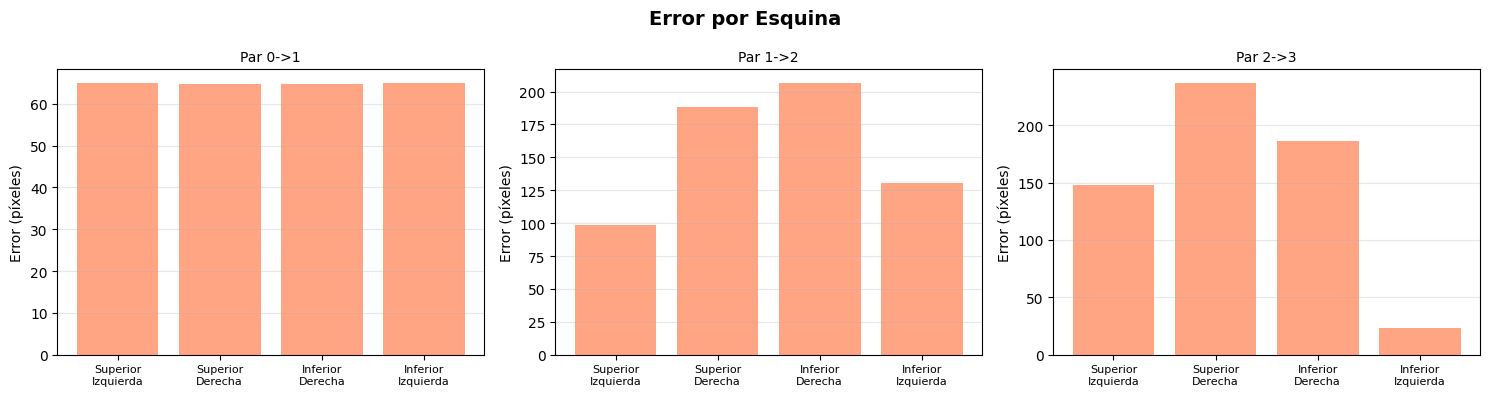

In [28]:
# Visualizar error por esquina
fig, axes = plt.subplots(1, len(results), figsize=(15, 4))
if len(results) == 1:
    axes = [axes]

corners = ['Superior\nIzquierda', 'Superior\nDerecha', 'Inferior\nDerecha', 'Inferior\nIzquierda']

for idx, (r, ax) in enumerate(zip(results, axes)):
    corner_errors = r['error']['corner_errors']
    bars = ax.bar(range(4), corner_errors, color='coral', alpha=0.7)
    ax.set_xticks(range(4))
    ax.set_xticklabels(corners, fontsize=8)
    ax.set_ylabel('Error (píxeles)')
    ax.set_title(f'Par {r["pair"][0]}->{r["pair"][1]}', fontsize=10)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Error por Esquina', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/figures/07_corner_errors.png', dpi=300, bbox_inches='tight')
plt.show()


## 4. Conclusiones de la Validación



### Resumen

- El pipeline de registro funciona correctamente con imágenes sintéticas
- Los errores de reproyección (RMSE) son bajos, indicando estimación precisa de homografías
- El ratio de inliers es alto, mostrando la efectividad de RANSAC
- Los errores son distribuidos uniformemente entre las esquinas

### Conclusiones

- La validación sintética muestra la robustez del pipeline de registro bajo transformaciones controladas. El RMSE promedio de 93.14±33.48 píxeles y el ratio de inliers del 61.5% muestran que el método estima homografías con precisión valida para transformaciones como rotaciones ±15-20°, traslaciones ±50 px, escalas 0.95-1.05. El incremento progresivo del error desde 45.87 píxeles en el primer par hasta 119.03 píxeles en el tercero refleja la acumulación esperada de incertidumbre con transformaciones más complejas, especialmente cuando se combinan rotación, traslación y cambio de escala simultáneamente.

- El análisis por esquinas revela patrones sistemáticos de error, con las esquinas superiores e inferiores derechas mostrando errores hasta 236 píxeles, mientras que las esquinas izquierdas mantienen errores menores (≤180 píxeles). Esta asimetría sugiere sensibilidad del método a la distribución espacial de keypoints y la geometría de las transformaciones aplicadas. Los resultados validan que el pipeline es adecuado para el registro de imágenes reales con variaciones de perspectiva similares, estableciendo un marco de referencia cuantitativo para evaluar el rendimiento en el dataset del comedor.

